# Registration initialization

I needed to re-think the image registration functions a little for *SuperTomo2*, because the capillary seems to somewhat distort the images, and also, many of the new images are for large part empty and thus some kind of masking was required. 

In [30]:
%matplotlib inline
import os
import numpy

from IPython.html.widgets import interact, fixed

from supertomo.io import image_data
from supertomo.ui import show

def show_axial_views(layer, data):
    show.display_2d_images(data[layer, :, :], numpy.amax(data[:],  axis=1),image1_title='XY', image2_title='XZ', vertical=True,)

def show_side_by_side(layer, image1, image2):
    show.display_2d_images(image1[layer, :, :], image2[layer, :, :], image1_title='Fixed', image2_title='Moving')

## Load Data

The *test_file_2.hdf5* contains two views from the experiment.

In [31]:
working_directory ="/home/sami/Data/2016_09_tomoSTED_bhk_single_structure/Import"
data_file = "test_file_3.hdf5"

full_path = os.path.join(working_directory,
                         data_file)

data = image_data.ImageData(full_path)


## Get two images to register

*fixed_image* is the regular STED image, whereas *moving_image* is the first rotated view.

In [32]:
fixed_index = 0
moving_index = 2
channel = 0
scale = 50
image_type = "original"

data.set_active_image(moving_index, channel, scale, image_type)
moving_image = data.get_itk_image()

data.set_active_image(fixed_index, channel, scale, image_type)
fixed_image = data.get_itk_image()

## Show *moving image*

The image is clearly tilted in ~30 degrees positive angle, as seen in the XZ axial view.

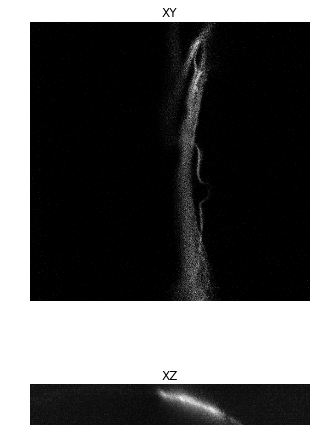

<function __main__.show_axial_views>

In [33]:

data.set_active_image(moving_index, channel, scale, image_type)

interact(show_axial_views, layer=(0, data.get_image_size()[0]-1, 1) , data=fixed(data[:]))

# Pre-rotate moving image

The orientation of the *moving image* can be roughly corrected by rotating it with the angle known from the experiment. 

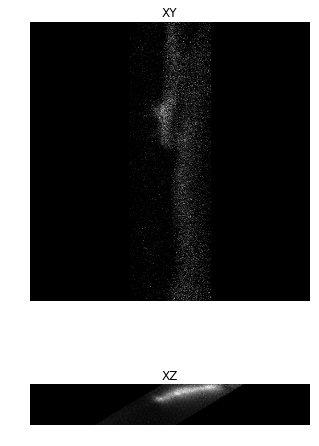

<function __main__.show_axial_views>

In [34]:
import SimpleITK as sitk
from supertomo.utils import itkutils

data.set_active_image(moving_index, channel, scale, image_type)

rotation_angle = data.get_rotation_angle(radians=False)
y_offset = 0.0
x_offset = 0.0
z_offset = 0.0

rotation = (numpy.pi/180) * rotation_angle


rotation_center = moving_image.TransformContinuousIndexToPhysicalPoint(
            [(index - 1) / 2.0 for index in moving_image.GetSize()])

manual_transform = sitk.Euler3DTransform()
manual_transform.SetCenter(rotation_center)
manual_transform.SetRotation(0, rotation, 0)
manual_transform.SetTranslation([y_offset, x_offset, z_offset])
modified_moving_image = itkutils.resample_image(moving_image, manual_transform)
    
interact(show_axial_views, 
         layer=(0, modified_moving_image.GetDepth()-1, 1), 
         data=fixed(itkutils.convert_to_numpy(modified_moving_image)[0]))

Continue with the centered transform initializer. The images are already very well overlaid.

# Create a binary mask for the similarity metric

Because both of the images are nearly empty, the sampling-based similarity metric does not work on the entire images. One can fix this by defining which regions of the image should be used for similarity calculation. The required spatial mask is calculated here.

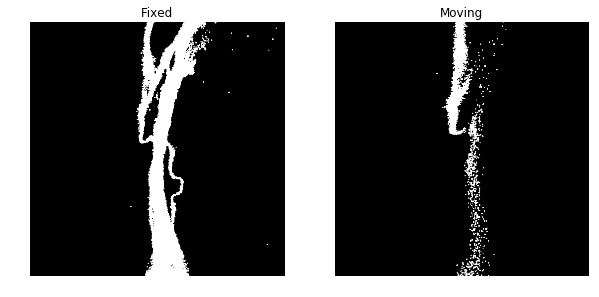

<function __main__.show_side_by_side>

In [35]:
registration = sitk.ImageRegistrationMethod()

fixed_mask = sitk.BinaryDilate(sitk.BinaryThreshold(fixed_image, 0, 30, 0, 1))
moving_mask = sitk.BinaryDilate(sitk.BinaryThreshold(modified_moving_image, 0, 30, 0, 1))

interact(show_side_by_side, 
         layer=(0, fixed_mask.GetDepth()-1, 1), 
         image1=fixed(itkutils.convert_to_numpy(fixed_mask)[0]),
         image2=fixed(itkutils.convert_to_numpy(moving_mask)[0])
         
        )

# Run initialization

The registration is started by calculating an initial transform that roughly overlays the moving and the fixed image. Please notice that the pre-rotated moving image is used here. An **affine** transform is used, because there is some deformation in the acquired images.

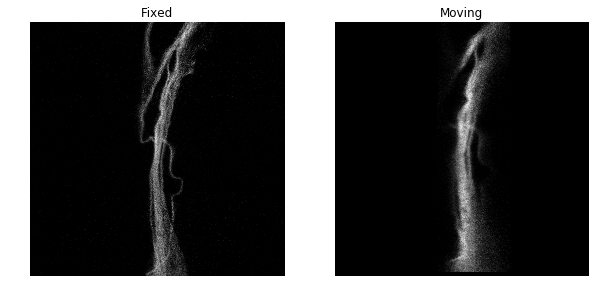

<function __main__.show_side_by_side>

In [36]:
transform = sitk.CenteredTransformInitializer(
                fixed_image,
                modified_moving_image,
                sitk.AffineTransform(3),
                sitk.CenteredTransformInitializerFilter.MOMENTS
            )


initialized_moving_image = itkutils.resample_image(modified_moving_image, transform, fixed_image)

interact(show_side_by_side, 
         layer=(0, initialized_moving_image.GetDepth()-1, 1), 
         image1=fixed(itkutils.convert_to_numpy(fixed_image)[0]),
         image2=fixed(itkutils.convert_to_numpy(initialized_moving_image)[0])
         
        )

# Run registration

The registration is run here. The *optimizer scales* and the learning rate are now estimated automatically.  

In [37]:
learning_rate = 1
min_step = 0.0005
max_iterations = 300
relaxation_factor = 0.8

mattes_histogram_bins = 30
mattes_sampling_percentage = 1


#Optimizer
registration.SetOptimizerAsRegularStepGradientDescent(
    learning_rate,
    min_step,
    max_iterations,
    relaxationFactor=relaxation_factor,
    estimateLearningRate=registration.EachIteration
    
)

registration.SetOptimizerScalesFromJacobian()

#Interpolator
registration.SetInterpolator(sitk.sitkLinear)

#Metric
#registration.SetMetricAsMattesMutualInformation(mattes_histogram_bins)

registration.SetMetricAsCorrelation()
registration.SetMetricSamplingStrategy(registration.RANDOM)
registration.SetMetricSamplingPercentage(mattes_sampling_percentage)

#Mask
registration.SetMetricFixedMask(fixed_mask)
registration.SetMetricMovingMask(moving_mask)


# Initial transform
registration.SetInitialTransform(transform)

final_transform = registration.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), 
                                       sitk.Cast(modified_moving_image, sitk.sitkFloat32))

print final_transform


itk::simple::Transform
 AffineTransform (0x2f62020)
   RTTI typeinfo:   itk::AffineTransform<double, 3u>
   Reference Count: 3
   Modified Time: 9339015
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     1.10783 0.00321356 0.860529 
     0.00127639 1.00242 0.204374 
     -0.234195 -0.0137847 0.659149 
   Offset: [-4.53236e-06, -3.08083e-06, 7.36159e-06]
   Center: [3.27789e-05, 3.02395e-05, 3.83318e-06]
   Translation: [2.39801e-06, -2.18246e-06, -2.03844e-06]
   Inverse: 
     0.708205 -0.0149209 -0.919945 
     -0.0519816 0.994448 -0.240473 
     0.250538 0.0154953 1.18522 
   Singular: 0



In [38]:
print('Final metric value: {0}'.format(registration.GetMetricValue()))
print('Optimizer\'s stopping condition, {0}'.format(registration.GetOptimizerStopConditionDescription()))

Final metric value: -0.617327789602
Optimizer's stopping condition, RegularStepGradientDescentOptimizerv4: Maximum number of iterations (300) exceeded.


# Show results

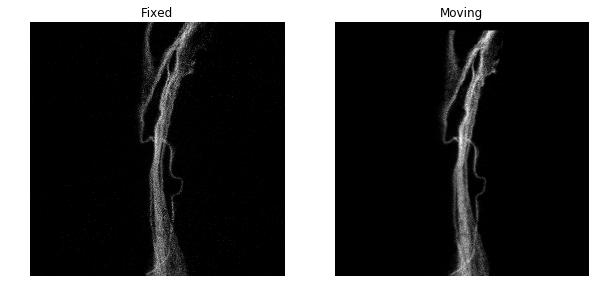

<function __main__.show_side_by_side>

In [39]:
result_image = itkutils.resample_image(modified_moving_image, final_transform, fixed_image)

interact(show_side_by_side, 
         layer=(0, fixed_image.GetDepth()-1, 1), 
         image1=fixed(itkutils.convert_to_numpy(fixed_image)[0]),
         image2=fixed(itkutils.convert_to_numpy(result_image)[0])
         
        )


In [44]:

result = itkutils.make_composite_rgb_image(fixed_image, result_image, return_numpy=True)[0]

show.evaluate_3d_image(result)

# Notes

I tested this with both of the rotated views. The registration works nicely now. It is important to keep the relaxation factor at approx. 0.8. I don't know why. The *cross-correlation* metric works better with these images at least. 

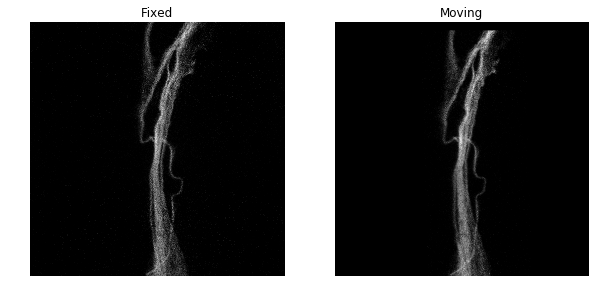

In [45]:
composite = sitk.Transform(manual_transform)
composite.AddTransform(final_transform)

result_image_2 = itkutils.resample_image(moving_image, composite, fixed_image)

interact(show_side_by_side, 
         layer=(0, fixed_image.GetDepth()-1, 1), 
         image1=fixed(itkutils.convert_to_numpy(fixed_image)[0]),
         image2=fixed(itkutils.convert_to_numpy(result_image_2)[0])
         
        )

result_2 = itkutils.make_composite_rgb_image(fixed_image, result_image_2, return_numpy=True)[0]

show.evaluate_3d_image(result_2)
